<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Initial_value_problems_Implicit_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical stability and implicit methods

Up until this point, we have been discussing *explicit* solver schemes, in which $y_{i+1}$ is determined using the information $x_i$ and $y_i$ with kowledge of $f(x_i, y_i)$.  

*Implicit* methods uses information at the new time step, in order to determine it; i.e.: using $f(x_{i+1}, y_{i+1})$! The new value of $y_{i+1}$ is therefore calcualted implicitly, for which we will generally need to use a root finder. The root finder adds significant computational expense but is substantially less sensative to numerical instability.

### The Backward Euler method

The simplest implicit scheme is the implicit Euler method (backward Euler). Like the forward Euler method we assumes a constant slope over the timestep but this time it is the slope *at the end of the timestep*:

$$ y_{i+1} = y_i + f(x_{i+1}, y_{i+1}) h$$

which implicitly defines $y_{i+1}$.

## Numerical instability

An algorithm is numerically unstable when small errors that occur during computation grow. Such errors can occur due to user-choices (e.g. - too large a step size) or simply round-off/truncation error.

NB: numerical instability is a property of the *algorithm*, not the equation.

#### Example: Initial value problem

Integrate $$\frac{\partial y}{\partial t} = - y$$

from 0 to 20 using the forward and backward Euler methods and compare to the exact solution,
$$ y(t) = e^{-t}$$

for varying step sizes.

In [14]:
# prompt: Can you make the above plot a slider for the step size ontop of the plot

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


def plot_with_slider(h):
  t0 =0
  t_end = 20
  y0 = 2
  # Time points
  t_points = np.arange(t0, t_end + h, h)

  # Analytical solution
  y_analytical = y0 * np.exp(-t_points)

  # Explicit Euler method
  y_explicit = np.zeros_like(t_points)
  y_explicit[0] = y0
  for i in range(1, len(t_points)):
      y_explicit[i] = y_explicit[i-1] * (1 - h)

  # Implicit Euler method
  y_implicit = np.zeros_like(t_points)
  y_implicit[0] = y0
  for i in range(1, len(t_points)):
      y_implicit[i] = y_implicit[i-1] / (1 + h)

  # Plotting the results
  plt.figure(figsize=(10, 6))
  plt.plot(t_points, y_analytical, label='Analytical Solution', color='black', linestyle='--')
  plt.plot(t_points, y_explicit, label='Explicit Euler', color='blue', marker='o')
  plt.plot(t_points, y_implicit, label='Implicit Euler', color='red', marker='x')
  plt.xlabel('Time')
  plt.ylabel('y(t)')
  plt.xlim(0, 20)
  plt.title('Comparison of Explicit and Implicit Euler Methods')
  plt.legend()
  plt.grid(True)
  plt.show()

interact(plot_with_slider, h=FloatSlider(min=.1, max=5, step=.1, value=0.8));

interactive(children=(FloatSlider(value=0.8, description='h', max=5.0, min=0.1), Output()), _dom_classes=('wid…

Gadzooks!

Let's consider the Forward Euler scheme analytically. For generality, say $\frac{dy}{dt} = -ay$ for some positive constant $a$,

$$\begin{align}
y_{i+1} &= y_i+h \frac{dy}{dt}(y_{i})  \\
&= y_i - y_i a h \\
&= y_i [1-a h]
\end{align} $$

In order for the solution to follow the smoothly decreasing behaviour, $h\lt\frac{1}{a}$. If $\frac{1}{a}\lt h \lt \frac{2}{a}$, the solution will overshoot but eventually correct itself. But if $h \gt \frac{2}{a}$ the method will catasrophically overcorrect!

Compare this to the implicit case,

$$\begin{align}
y_{i+1} &= y_i+h \frac{dy}{dt}(y_{i+1}) \\
&= y_i - y_{i+1} a h \\
y_{i+1}&= \frac{y_i}{1+ah}
\end{align} $$

which is nicely decreasing for all $h>0$ and is therefore *unconditionally stable*!




Numerical stability has therefore placed a limit on the step size for which a method will converge on the correct answer. There are different types of stability, which  is outside the scope of this course.

The stability of the explicit vs implicit Euler methods helps show some intuition on what's going on: since implicit schemes focus on the end of the time step and how we *got there*, they are less sensative to errors introduced by large time steps or numerical noise.

##Stiffness

One might think that the adaptive time steppers may dynamically avoid numerical instability but you would be dissappointed...

Consider the equation
$$ \frac{dy}{dt} = -1000 y + 3000 - 2000 e^{-t}$$ with $y(0) = 0$.

The analytical solution is $$y(t) = 3-0.998 e^{-1000 t} - 2.0-2 e^{-t}$$ which features a fasts transient due to $e^{-1000 t}$ followed by a slow progression:

In [15]:
# prompt: plot 3-0.998 e^{-1000 t} - 2.0-2 e^{-t} from 0 to a limit determined by a slider starting at 3

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def plot_function(limit):
  t = np.linspace(0, limit, 500)
  y = 3 - 0.998 * np.exp(-1000 * t) - 2 - 2 * np.exp(-t)
  plt.figure(figsize=(10, 6))
  plt.plot(t, y)
  plt.xlabel('t')
  plt.ylabel('y(t)')
  plt.title('Plot of y(t) = 3 - 0.998e^(-1000t) - 2 - 2e^(-t)')
  plt.grid(True)
  plt.show()

interact(plot_function, limit=FloatSlider(min=.1, max=5, step=0.1, value=3));

interactive(children=(FloatSlider(value=3.0, description='limit', max=5.0, min=0.1), Output()), _dom_classes=(…

The stability of the fast term with forward Euler requires $h\lt \frac{2}{1000}$ to not catastrophically overcorrect, but at least that is only for the first little bit right?

Wrong. Even though the transient only dominates the behaviour for the first little bit, it is still there for the rest, and will still tear shirt up!

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


def plot_with_slider(h):
  t0 =0.01
  t_end = .05
  y0 = 0.
  # Time points
  t_points = np.arange(t0, t_end + h, h)

  # Analytical solution
  def y_true(t):
    return 3. - 0.998*np.exp(-1000*t)  - 2.002*np.exp(-t)
  y_analytical = y_true(t_points)

  y0 = y_true(t0)

  def f(y,t):
    return -1000.*y + 3000. - 2000.*np.exp(-t)

  # Explicit Euler method
  y_explicit = np.zeros_like(t_points)
  y_explicit[0] = y0
  for i in range(1, len(t_points)):
      y_explicit[i] = y_explicit[i-1] + f(y_explicit[i-1], t_points[i-1]) * h

  # Implicit Euler method
  y_implicit = np.zeros_like(t_points)
  y_implicit[0] = y0
  def imp(y, t, y0, f, h):
    return y - (y0 + h*f(y, t))

  from scipy.optimize import root
  for i in range(1, len(t_points)):
      sol = root(imp, y_implicit[i-1], args=(t_points[i], y_implicit[i-1], f, h))
      y_implicit[i] = sol.x[0]

  # Plotting the results
  plt.figure(figsize=(10, 6))
  plt.plot(t_points, y_analytical, label='Analytical Solution', color='black', linestyle='--')
  plt.plot(t_points, y_explicit, label='Explicit Euler', color='blue', marker='o')
  plt.plot(t_points, y_implicit, label='Implicit Euler', color='red', marker='x')
  plt.xlabel('Time')
  plt.ylabel('y(t)')
  plt.xlim(t0, t_end)
  plt.title('Comparison of Explicit and Implicit Euler Methods')
  plt.legend()
  plt.grid(True)
  plt.show()

interact(plot_with_slider, h=FloatSlider(min=.0001, max=.003, step=.0001, value=0.0005, readout_format='.4f'));

interactive(children=(FloatSlider(value=0.0005, description='h', max=0.003, min=0.0001, readout_format='.4f', …

###Definition of stiffness

A precise mathematical definition of stiffness is difficult, but in general: A stiff equation is one in which accuracy of the solution is determined by numerical stability rather than the behaviour of the solution.

This is expecially problematic in physics where short transients as a system reaches a 'well behaved state' are common. If we include the phenomena which describe the transients, we are bound by their timescales weather or not the transient has died off!

One approach is to ignore the transients entirely! Examples include:
- Quasistatic elasticity
- diffusive heat / mass transport
- etc.

Alternately, we can use implicit methods which are more stable, but come with added computational expense.

## Implicit Runge-Kutta methods

We are now in a position to generalize the RK methods. Recalling:

$$ y_{i+1} \approx y_i + h \sum_{n=1}^s a_n k_n$$

with

$$
k_n = f(x_i + p_n, y_i + \sum_{m=1}^s q_{nm}k_m)
$$

the Butcher tableau now expanded:


$$
\begin{array}{c|cccc}
p_1 & q_{11} & q_{12} & \dots & q_{1s} \\
p_2 & q_{21} & q_{22} & \dots & q_{2s} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
p_s & q_{s1} & q_{s2} & \dots & q_{ss} \\
\hline
 & a_1 & a_2 & \dots & a_s
\end{array}
$$

In explicit methods, the $k_n$s could be built progressively on $k_{n-1...}$, but this is not the case for implicit RK. Rather, a set of $k_n$ may need to be solved *simultaneously* which can dramatically amplify the computaitonal expense.

The balance of computaional expense to increased accuracy has motivated a  plethora of RK methods of varying stages, orders, and complexity of which we will only discuss a few:

### Implicit Euler method

The Implicit Euler, $$ y_{i+1} = y_i + f(x_{i+1}, y_{i+1}) h$$ has the tableau:

$$
\begin{array}{c|c}
1 & 1 \\
\hline
  & 1 \\
\end{array}
$$

### RK2 implicit

#### Implicit midpoint method

$$ \begin{align}
y_{i+1} &= y_i + h k_1
\end{align}$$
where

$$k_1 = f(x_{i+\frac{1}{2}}, y_{i+\frac{1}{2}}) $$
which is found through the implicit solution of:
$$y_{i+\frac{1}{2}} = y_n + \frac{h}{2} f\big(x_i+\frac{1}{2}h, y_{i+\frac{1}{2}}\big)$$




and has the Butcher Tableau,
$$
\begin{array}{c|c}
\frac{1}{2} & \frac{1}{2} \\
\hline
  & 1 \\
\end{array}
$$

#### Implicit trapezoid / Crank-Nicholson method


$$
y_{n+1} = y_n + \frac{h}{2} \left( f(t_n, y_n) + f(t_{n+1}, y_{n+1}) \right)
$$

with Tableau
$$
\begin{array}{c|cc}
0 & 0 & 0 \\
1 & \frac{1}{2} & \frac{1}{2} \\
\hline
  & \frac{1}{2} & \frac{1}{2} \\
\end{array}
$$

#### Gauss-Legendre order 4 (2 stages)

As an example of the complexity, the Gauss-Legendre order 4 method has a tableau,
$$
\begin{array}{c|cc}
\frac{1}{2} - \frac{\sqrt{3}}{6} & \frac{1}{4} & \frac{1}{4} - \frac{\sqrt{3}}{6} \\
\frac{1}{2} + \frac{\sqrt{3}}{6} & \frac{1}{4} + \frac{\sqrt{3}}{6} & \frac{1}{4} \\
\hline
  & \frac{1}{2} & \frac{1}{2} \\
\end{array}
$$

such that

$$
\begin{align*}
k_1 &= f\left(t_n + \left(\frac{1}{2} - \frac{\sqrt{3}}{6}\right)h, y_n + h\left(\frac{1}{4}k_1 + \left(\frac{1}{4} - \frac{\sqrt{3}}{6}\right)k_2\right)\right) \\
k_2 &= f\left(t_n + \left(\frac{1}{2} + \frac{\sqrt{3}}{6}\right)h, y_n + h\left(\left(\frac{1}{4} + \frac{\sqrt{3}}{6}\right)k_1 + \frac{1}{4}k_2\right)\right)
\end{align*}
$$

with the update for \( y_{n+1} \) is then given by:

$$
y_{n+1} = y_n + h\left(\frac{1}{2}k_1 + \frac{1}{2}k_2\right)
$$

[and so on](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods).

## Systems of equations

In many engineering problems we will have a system of equations which depend on a single parameter:

$$\begin{align}
\frac{dy_1}{dt} &= f_1(x, y_1, y_2, ..., y_j) \\
\frac{dy_2}{dt} &= f_2(x, y_1, y_2, ..., y_j) \\
\vdots \\
\frac{dy_j}{dt} &= f_j(x, y_1, y_2, ..., y_j) \\
\end{align}$$

Happily, extension of the Runge-Kutta methods is straightforward! Collecting functions as a vector, we get the vector RK form:

$$ \vec{y}_{i+1} \approx \vec{y}_i + h \sum_{n=1}^s a_n \vec{k}_n$$

with

$$
\vec{k}_n = \vec{f}(x_i + p_n, \vec{y}_i + \sum_{m=1}^s q_{nm}\vec{k}_m)
$$


## Reduction of order

Up to this point, we have only discussed first-order differential equations. Higher order differential equations can be reduced to a system of first order equations by defining new unknowns:

$$ \begin{align}
y^{\prime\prime} &= f(x, y, y^\prime)
\end{align} $$

Let $z = y^\prime$, such that

$$ \begin{align}
z^{\prime} &= f(x, y, z) \\
y^{\prime} &= z
\end{align} $$

which is solved as a system of equations as above.



#### Example: Swinging pendulum

The equation of motion of a swinging pendulum is,
$$ ml \frac{d^2\Theta(t)}{dt^2} = -m g \sin\big( \Theta(t) \big)$$

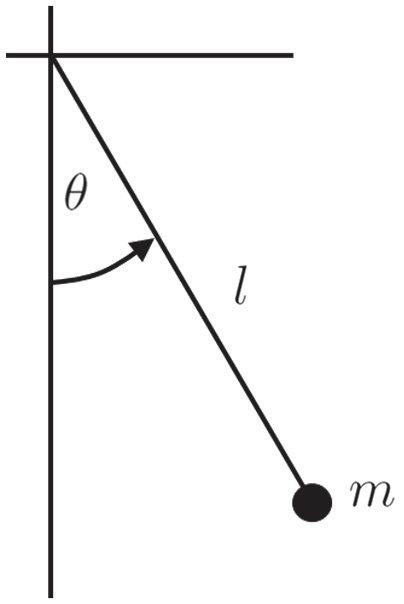

Use the reduction of order to write:

$$ \vec{y} = \begin{bmatrix} \Theta(t) \\ \dot{\Theta}(t) \end{bmatrix} $$

$$\frac{d\vec{y}}{dt} = \begin{bmatrix} \dot{\Theta}(t) \\ \ddot{\Theta}(t) \end{bmatrix} = \begin{bmatrix} y_2 \\ g \sin(y_1)/l  \end{bmatrix}  = \vec{f}(t, \vec{y})$$

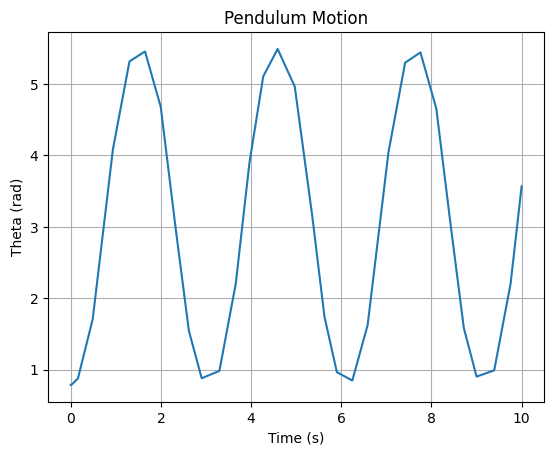

In [6]:
# prompt: Sovle the above with RK45

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.integrate import solve_ivp

# Define the system of differential equations
def f(t, y):
  theta, theta_dot = y
  g = 9.81  # Acceleration due to gravity (m/s^2)
  l = 1.0   # Length of the pendulum (m)
  dydt = [theta_dot, (g/l) * np.sin(theta)]
  return np.array(dydt)

# Initial conditions
theta0 = np.pi/4  # Initial angle (radians)
theta_dot0 = 0.0  # Initial angular velocity (rad/s)

# Time span
t_span = (0, 10)

# Solve using RK45
sol = solve_ivp(f, t_span, [theta0, theta_dot0], method='RK45')

# Plot the results
plt.plot(sol.t, sol.y[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Pendulum Motion')
plt.grid(True)
plt.show()

#Multistep methods

Multistep methods are an approach to exploit the history of solutions $y_{\le i}$ in the calculation of the next step $y_{i+1}$. Note that since they exploit a history, they require *bootstrapping* in order to get started.

In general we know that
$$ \begin{align}
\frac{dy}{dx} &= f(x,y) \\
\int dy &= \int f(x,y) dx\\
y_{i+1} &= y_i + \int f(x,y) dx
\end{align}$$

but remember we have formulae for integration which amounts to weighted sums of the function at different points! We can then expand the right hand side and write a General Linear Multistep formula:

$$
\sum_{j=0}^{s} \alpha_j y_{i+j} = h \sum_{j=0}^{s} \beta_j f(t_{i+j}, y_{i+j})
$$


where the $\alpha_j$ and $\beta_j$ coefficients are chosen for accuracy and balance of computation. Note that this indexing is a matter of stype; in general we are interested in the final solution $y_{i+s}$, and $\alpha_s=1$ as a matter of normalization and convenience.

##Explicit linear multistep methods

When $\beta_s = 0$, the final solution, $y_i+s$ depends only on previous solutions and is therefore explicit.

This scheme is often used to generate a *predictor* based solely on what has happened before. While a good guess, it must be *corrected* using some kind of scheme like Heun's method in order to capture anything that happened during the interval.

This scheme does not handle unevenly spaced steps (a significant shortfall!), and doesn't self-start. Moreover, explicit single-step methods generally outperform these, and they are seldom used.

## Backward Difference Formulae: Implicit linear multistep methods

If we say $\beta_{j\ne s}=0$, we arrive at the implicit linear multistep method, better known as the Backward Difference Formulae which is the default for many modern computational tools.

Starting from: $\frac{dy}{dx} = f(x,y)$, the $\alpha_j$ coefficients are found from the derivative of a Lagrange interpolation polynomial fit to the distory:  $<x_n, y_n> ... <x_{n+s}, y_{n+s}>$.

The first 5 orders are:

$$ \begin{align}
y_{n+1}^{(1)} &= y_n + h f(x_{n+1}, y_{n+1})\\
y_{n+1}^{(2)} &= \frac{4}{3} y_n - \frac{1}{3} y_{n-1} + \frac{2}{3} h f(x_{n+1}, y_{n+1})\\
y_{n+1}^{(3)} &= \frac{18}{11} y_n - \frac{9}{11} y_{n-1} + \frac{2}{11} y_{n-2} + \frac{6}{11} h f(x_{n+1}, y_{n+1})\\
y_{n+1}^{(4)} &= \frac{48}{25} y_n - \frac{36}{25} y_{n-1} + \frac{16}{25} y_{n-2} - \frac{3}{25} y_{n-3} + \frac{12}{25} h f(x_{n+1}, y_{n+1})\\
y_{n+1}^{(5)} &= \frac{300}{137} y_n - \frac{300}{137} y_{n-1} + \frac{120}{137} y_{n-2} - \frac{25}{137} y_{n-3} + \frac{12}{137} y_{n-4} + \frac{60}{137} h f(x_{n+1}, y_{n+1})
\end{align}
$$

Note that the Backward Euler method is BDF1.

The benefits of BDFs are:
* There is no requirement for a constant step size
* It is implicit and therefore good for stiff equations
* One can dynamically change between orders to self-start and restart if the physics change.

#Summary of initial value problems

Explicit methods:
* Easy to calculate.
* Parallelize well.
* Suffer from numerical instability.
* Require small step sizes for stiff equations.

Implicit methods:
* Computationally intensive (general require root finding / linear systems).
* Don't parallelize well.
* Are much more numerically stable.
* Can take *significantly* larger step sizes without diverging.

Systems of equations are natural and ready extensions of the methods.

Reduction of order can be applied to higher order derivatives.

Adaptive time stepping is very important and can be achieved through clever (or brute force) methods without much additional expense.

The explicit Runge-Kutta methods efficiently achieve accurate estimates if numerical instability isn't a factor.

Implicit RK methods require simultaneous solutoin of several equations which can exponenetially increase the computaitonal cost.

Explicit linear multistep methods have conditions which make them impractical.

Implicit linear multistep (Backward Differential Formulas: BDF) methods have excellent properties while exploiting the solution history.

# Dr. Mike's tips:

* Know your physics. If you don't, go with an adaptive BDF method (the default of most software).
* If you know your system is not stiff, RK45 is the go-to and you will substantially benefit in computer time.
* If you know your physics has abrupt changes (e.g.: steps / pulses) consider keeping with Backward Euler - no higher-order accuracy is possible.  